In [1]:
import nltk

In [2]:
# Set random seed
seed = 123
# Data manipulation/analysis
import numpy as np
import pandas as pd
# Text preprocessing/analysis
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
from scipy.sparse import hstack, csr_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
# Modelling
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style="whitegrid", context='talk')


In [3]:
sample = pd.read_csv('tweets_combined_edited.csv')
#print(f"{sample.shape[0]} rows and {sample.shape[1]} columns")
sample.head()

,tweet,sentiment
0,Today in Selfcare: beauty &amp; laughs Kung Fu...,positive
1,I get to spend New Year's home again alone and...,negative
2,"Depressed and lonely /: Stuck in a deep, never...",negative
3,If this is your response to someone saying the...,negative
4,Apparently you get a free pass just by mention...,positive


In [4]:
#looking at splits 1 for negative 0 for positive
sample['sentiment'].value_counts()

positive    2226
negative     974
Name: sentiment, dtype: int64

In [5]:
file = 'sentiment140_processedv3.csv' 

import chardet
with open(file, 'rb') as rawdata:
    result = chardet.detect(rawdata.read(100000))
result


df= pd.read_csv(file,encoding='ISO-8859-1')

df.head()

,Unnamed: 0,tweet,sentiment,new_tweets
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",negative,switchfoot awww that s bummer shoulda get davi...
1,1,is upset that he can't update his Facebook by ...,negative,upset ca nt update facebook texting might cry ...
2,2,@Kenichan I dived many times for the ball. Man...,negative,kenichan dive many time ball manage save 50 re...
3,3,my whole body feels itchy and like its on fire,negative,whole body feel itchy like fire
4,4,"@nationwideclass no, it's not behaving at all....",negative,nationwideclass behaving I m mad ca nt see


In [6]:
df['sentiment'].value_counts()

negative    532088
positive     32950
Name: sentiment, dtype: int64

In [7]:
# Encode to numeric
sample['target'] = np.where(sample['sentiment']=='positive', 0, 1)
# Check values
sample.groupby(['sentiment', 'target']).count().unstack()

tweet       
target          0      1
sentiment               
negative      NaN  974.0
positive   2226.0    NaN

In [8]:
# Select the ones you want
df1 = df[['new_tweets','sentiment']]

# Encode to numeric
df1['target'] = np.where(df['sentiment']=='positive', 1, 0)
# Check values
df1.groupby(['sentiment', 'target']).count().unstack()

<ipython-input-8-a32ac6d22d91>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['target'] = np.where(df['sentiment']=='positive', 1, 0)


new_tweets         
target             0        1
sentiment                    
negative    531930.0      NaN
positive         NaN  32939.0

In [9]:
X_train, X_test, y_train, y_test = train_test_split(sample['tweet'], sample['target'], test_size=20, random_state=seed)

train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

print(f"Train: {train.shape[0]} rows and {train.shape[1]} columns")
print(f"{train['target'].value_counts()}\n")
print(f"Test: {test.shape[0]} rows and {test.shape[1]} columns")
print(test['target'].value_counts())

Train: 3180 rows and 2 columns
0    2209
1     971
Name: target, dtype: int64

Test: 20 rows and 2 columns
0    17
1     3
Name: target, dtype: int64


In [10]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(df1['new_tweets'], df1['target'], test_size=560000, random_state=seed)

train1 = pd.concat([X_train1, y_train1], axis=1)
test1 = pd.concat([X_test1, y_test1], axis=1)

print(f"Train1: {train1.shape[0]} rows and {train1.shape[1]} columns")
print(f"{train1['target'].value_counts()}\n")
print(f"Test1: {test1.shape[0]} rows and {test1.shape[1]} columns")
print(test1['target'].value_counts())

Train1: 5038 rows and 2 columns
0    4730
1     308
Name: target, dtype: int64

Test1: 560000 rows and 2 columns
0    527358
1     32642
Name: target, dtype: int64


In [11]:
train.head()

,tweet,target
2503,I just feelso defeated by life at the moment,1
748,just tryna talk to somone and they got to be c...,1
80,"""Anxiety is like a tornado, the most violent, ...",1
1611,this year was fuckd up I can't wait for it to ...,1
2849,Human being is a design of expression that des...,0


In [12]:
test1.head()

,new_tweets,target
28754,layc enough time day,0
8403,31 patch today wow maybe next week,0
174014,soozafritz I m bored get nothing,0
557399,xkayteebear okay dunno xd haha I m listen alwa...,1
538668,tommcfly woooo go tom get break dawn xx,1


In [13]:
sid = SentimentIntensityAnalyzer()

In [14]:
train[['neg', 'neu', 'pos', 'compound']] = train['tweet'].apply(sid.polarity_scores).apply(pd.Series)
train.head()

,tweet,target,neg,neu,pos,compound
2503,I just feelso defeated by life at the moment,1,0.307,0.693,0.000,-0.4767
748,just tryna talk to somone and they got to be c...,1,0.365,0.635,0.000,-0.8481
80,"""Anxiety is like a tornado, the most violent, ...",1,0.605,0.291,0.104,-0.9197
1611,this year was fuckd up I can't wait for it to ...,1,0.330,0.670,0.000,-0.8708
2849,Human being is a design of expression that des...,0,0.000,1.000,0.000,0.0000


C:\Users\user\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


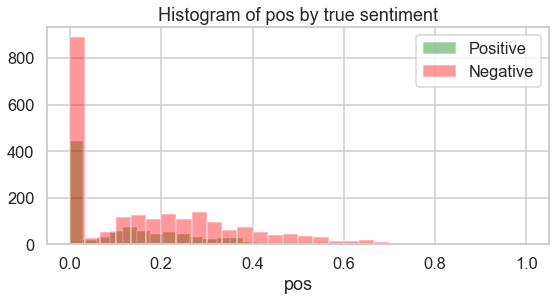

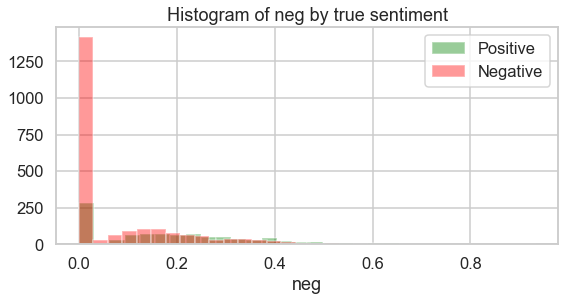

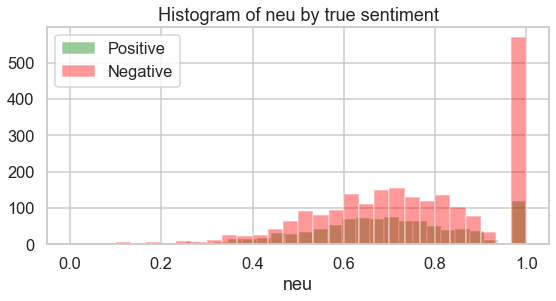

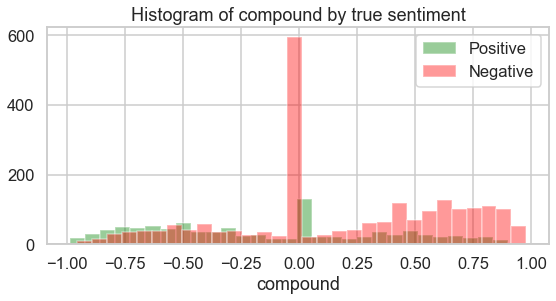

In [15]:
for var in ['pos', 'neg', 'neu', 'compound']:
    plt.figure(figsize=(9,4))
    sns.distplot(train.query("target==1")[var], bins=30, kde=False, 
                 color='green', label='Positive')
    sns.distplot(train.query("target==0")[var], bins=30, kde=False, 
                 color='red', label='Negative')
    plt.legend()
    plt.title(f'Histogram of {var} by true sentiment');

In [16]:
train['vader_polarity'] = np.where(train['pos']>train['neg'], 0, 1)
target_names=['negative', 'positive']
print(classification_report(train['target'], 
                            train['vader_polarity'], 
                            target_names=target_names))

              precision    recall  f1-score   support

    negative       0.78      0.51      0.62      2209
    positive       0.38      0.68      0.49       971

    accuracy                           0.56      3180
   macro avg       0.58      0.60      0.55      3180
weighted avg       0.66      0.56      0.58      3180



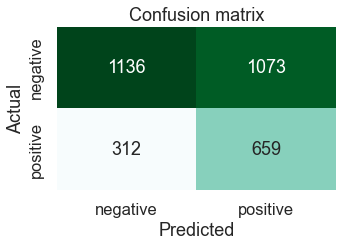

In [17]:
# Create function so that we could reuse later
def plot_cm(y_test, y_pred, target_names=['negative', 'positive'], 
            figsize=(5,3)):
    """Create a labelled confusion matrix plot."""
    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=True, fmt='g', cmap='BuGn', cbar=False, 
                ax=ax)
    ax.set_title('Confusion matrix')
    ax.set_xlabel('Predicted')
    ax.set_xticklabels(target_names)
    ax.set_ylabel('Actual')
    ax.set_yticklabels(target_names, 
                       fontdict={'verticalalignment': 'center'});
# Plot confusion matrix
plot_cm(train['target'], train['vader_polarity'])

In [18]:
train['vader_compound'] = np.where(train['compound']>0, 1, 0)
print(classification_report(train['target'], 
                            train['vader_compound'], 
                            target_names=target_names))

              precision    recall  f1-score   support

    negative       0.62      0.49      0.55      2209
    positive       0.22      0.32      0.26       971

    accuracy                           0.44      3180
   macro avg       0.42      0.40      0.40      3180
weighted avg       0.50      0.44      0.46      3180



In [19]:
# Define functions
def create_baseline_models():
    """Create list of baseline models."""
    models = []
    models.append(('log', LogisticRegression(random_state=seed, 
                                             max_iter=1000)))
    models.append(('sgd', SGDClassifier(random_state=seed)))
    models.append(('mnb', MultinomialNB()))
    return models
def assess(X, y, models, cv=5, scoring=['roc_auc', 
                                        'accuracy', 
                                        'f1']):
    """Provide summary of cross validation results for models."""
    results = pd.DataFrame()
    for name, model in models:
        result = pd.DataFrame(cross_validate(model, X, y, cv=cv, 
                                             scoring=scoring))
        mean = result.mean().rename('{}_mean'.format)
        std = result.std().rename('{}_std'.format)
        results[name] = pd.concat([mean, std], axis=0)
    return results.sort_index()

In [20]:
models = create_baseline_models()
models

[('log', LogisticRegression(max_iter=1000, random_state=123)),
 ('sgd', SGDClassifier(random_state=123)),
 ('mnb', MultinomialNB())]

In [21]:
# Preprocess the data
vectoriser = TfidfVectorizer(token_pattern=r'[a-z]+', 
                             stop_words='english', 
                             min_df=30, 
                             max_df=.7)
X_train_simpler = vectoriser.fit_transform(X_train)

print(X_train_simpler)

# Assess the model
assess(X_train_simpler, y_train, models)

  (0, 48)	0.7592679206795689
  (0, 45)	0.6507781685235944
  (1, 31)	0.5442859823678282
  (1, 82)	0.5927684894049895
  (1, 48)	0.4507125192111256
  (1, 45)	0.3863114189262025
  (2, 49)	1.0
  (3, 27)	0.3993187465639052
  (3, 88)	0.3152059265717668
  (3, 35)	0.397554963453998
  (3, 16)	0.3738431639621583
  (3, 81)	0.22105355239156685
  (3, 106)	0.6281054284621232
  (5, 98)	0.7883885199652869
  (5, 45)	0.6151776504286746
  (6, 10)	0.7738757793334674
  (6, 55)	0.6333374125701232
  (8, 14)	0.44718850737524596
  (8, 8)	0.6133193596598102
  (8, 34)	0.4465806961171739
  (8, 55)	0.4737377795716533
  (9, 11)	0.28689621725181075
  (9, 93)	0.28094698828134557
  (9, 71)	0.28573016767958853
  (9, 89)	0.34981323582100193
  :	:
  (3172, 20)	0.43127560133909815
  (3172, 81)	0.3335863326793574
  (3173, 37)	1.0
  (3174, 107)	0.48481194785137127
  (3174, 20)	0.3544585452029174
  (3174, 65)	0.42037115956759413
  (3174, 81)	0.27416929177992416
  (3174, 106)	0.3895147094934354
  (3174, 48)	0.3686275810292846


,log,sgd,mnb
fit_time_mean,0.080085,0.035570,0.001799
fit_time_std,0.115948,0.053354,0.000447
score_time_mean,0.002997,0.004398,0.003598
score_time_std,0.000006,0.001136,0.000548
test_accuracy_mean,0.748428,0.739623,0.739937
test_accuracy_std,0.020889,0.023178,0.009073
test_f1_mean,0.465489,0.465073,0.375619
test_f1_std,0.038777,0.047851,0.020486
test_roc_auc_mean,0.756019,0.739810,0.745362
test_roc_auc_std,0.020570,0.019021,0.021650


In [22]:

# Define function
def preprocess_text(text):
    # 1. Tokenise to alphabetic tokens
    tokeniser = RegexpTokenizer(r'[A-Za-z]+')
    tokens = tokeniser.tokenize(text)
    
    # 2. Lowercase and lemmatise 
    lemmatiser = WordNetLemmatizer()
    tokens = [lemmatiser.lemmatize(t.lower(), pos='v') 
              for t in tokens]
    return tokens
# Preprocess the data
vectoriser = TfidfVectorizer(analyzer=preprocess_text, 
                             min_df=30, 
                             max_df=.7)
X_train_simple = vectoriser.fit_transform(X_train)
# Assess models
assess(X_train_simple, y_train, models)

,log,sgd,mnb
fit_time_mean,0.031382,0.010396,1.998997e-03
fit_time_std,0.002875,0.000892,6.868773e-07
score_time_mean,0.003198,0.002598,2.998352e-03
score_time_std,0.000447,0.000547,4.460403e-07
test_accuracy_mean,0.768239,0.755975,7.443396e-01
test_accuracy_std,0.020154,0.019714,1.069876e-02
test_f1_mean,0.525241,0.557850,3.503123e-01
test_f1_std,0.042345,0.037499,1.132237e-02
test_roc_auc_mean,0.801385,0.792329,7.905033e-01
test_roc_auc_std,0.022734,0.022030,2.586095e-02


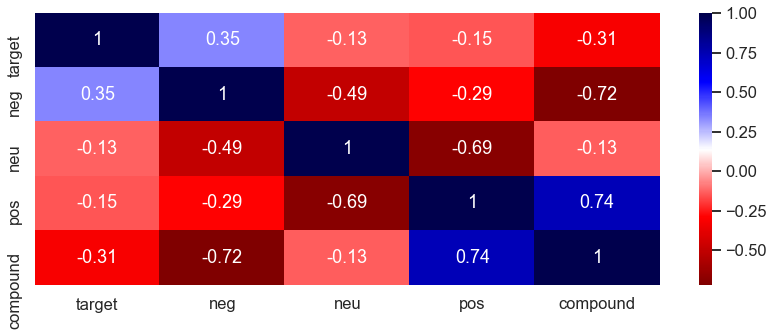

In [23]:
plt.figure(figsize = (14,5))
columns = ['target', 'neg', 'neu', 'pos', 'compound']
sns.heatmap(train[columns].corr(), annot=True, cmap='seismic_r');

In [24]:
# Initialise a model
sgd = SGDClassifier(random_state=seed)
# Initialise a scaler
scaler = MinMaxScaler()
# Assess the model using scores
scores = train[['neg', 'neu', 'pos', 'compound']]
assess(scaler.fit_transform(scores), y_train, [('sgd', sgd)])

,sgd
fit_time_mean,0.014793
fit_time_std,0.008009
score_time_mean,0.030098
score_time_std,0.058942
test_accuracy_mean,0.716667
test_accuracy_std,0.017872
test_f1_mean,0.372829
test_f1_std,0.127010
test_roc_auc_mean,0.716753
test_roc_auc_std,0.032858


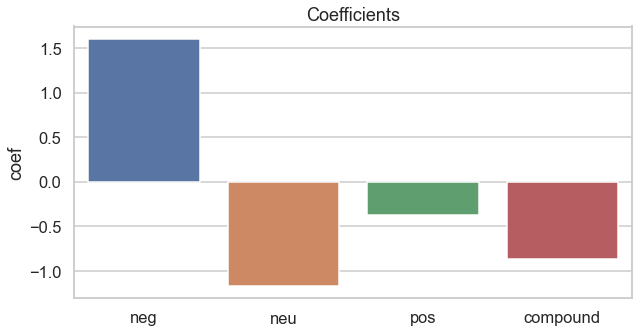

In [25]:
# Fit to training data
sgd.fit(scores, y_train)
# Get coefficients
coefs = pd.DataFrame(data=sgd.coef_, columns=scores.columns).T
coefs.rename(columns={0: 'coef'}, inplace=True)
# Plot
plt.figure(figsize=(10,5))
sns.barplot(x=coefs.index, y='coef', data=coefs)
plt.title('Coefficients');

In [26]:


pipe = Pipeline([('vectoriser', TfidfVectorizer(encoding='ISO-8859-1',token_pattern=r'[a-z]+', min_df=30, max_df=.6, ngram_range=(1,2))),
                 ('model', SGDClassifier(random_state=seed, loss='log'))])
pipe.fit(X_train.values.astype('U'),y_train)



Pipeline(steps=[('vectoriser',
                 TfidfVectorizer(encoding='ISO-8859-1', max_df=0.6, min_df=30,
                                 ngram_range=(1, 2), token_pattern='[a-z]+')),
                ('model', SGDClassifier(loss='log', random_state=123))])

In [27]:
coefs = pd.DataFrame(pipe['model'].coef_, 
                     columns=pipe['vectoriser'].get_feature_names())
coefs = coefs.T.rename(columns={0:'coef'}).sort_values('coef')
coefs

,coef
blessed,-3.206050
start,-2.630387
n,-2.568530
amp,-2.518822
tomorrow,-2.365388
...,...
person,3.076867
depressed,3.956475
pain,4.010422
sad,4.039698


In [28]:
train_pred = pipe.predict(X_train)
print(classification_report(train_pred, 
                            y_train, 
                            target_names=target_names))

              precision    recall  f1-score   support

    negative       0.93      0.81      0.87      2541
    positive       0.51      0.77      0.61       639

    accuracy                           0.80      3180
   macro avg       0.72      0.79      0.74      3180
weighted avg       0.85      0.80      0.82      3180



In [29]:
train_pred = pipe.predict(X_test)
print(classification_report(train_pred, 
                            y_test, 
                            target_names=target_names))

              precision    recall  f1-score   support

    negative       1.00      0.94      0.97        18
    positive       0.67      1.00      0.80         2

    accuracy                           0.95        20
   macro avg       0.83      0.97      0.89        20
weighted avg       0.97      0.95      0.95        20



In [30]:
train_pred = pipe.predict(X_train1.values.astype('U'))
print(classification_report(train_pred, 
                            y_train1, 
                            target_names=target_names))

              precision    recall  f1-score   support

    negative       0.90      0.93      0.92      4547
    positive       0.04      0.02      0.03       491

    accuracy                           0.85      5038
   macro avg       0.47      0.48      0.47      5038
weighted avg       0.81      0.85      0.83      5038



In [31]:
test_pred = pipe.predict(X_test1.values.astype('U'))
print(classification_report(test_pred, 
                            y_test1, 
                            target_names=target_names))

              precision    recall  f1-score   support

    negative       0.90      0.94      0.92    505758
    positive       0.03      0.02      0.03     54242

    accuracy                           0.85    560000
   macro avg       0.47      0.48      0.47    560000
weighted avg       0.82      0.85      0.83    560000

